# Nest Dataset

## Imports

In [33]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

Consider how you would analyze a real-time IoT dataset. We have a Nest device under normal conditions. How would detect malicious or anomalous events from this data using machine learning models?
 
Questions to consider for your analysis include:
1. What type of model(s) would you choose and why?
2. What kind of feature engineering would you want to do? Is there additional data you would want to capture?
3. What would be needed to integrate your approach into the product's overall architecture?

## Load Data

In [34]:
df = pd.read_csv('data/DeviceTraffic.csv')

pd.set_option('display.max_colwidth', None)
print(df.shape)
df.head()

(5955, 7)


,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,74.125.138.95,10.0.0.169,TLSv1.2,111,Application Data
1,2,0.007024,10.0.0.169,74.125.138.95,TCP,66,58031 > 443 [ACK] Seq=1 Ack=46 Win=406 Len=0 TSval=536764 TSecr=1926011217
2,3,0.291968,10.0.0.169,74.125.196.99,TCP,74,32864 > 443 [SYN] Seq=0 Win=14600 Len=0 MSS=1460 SACK_PERM=1 TSval=536793 TSecr=0 WS=64
3,4,0.321301,74.125.196.99,10.0.0.169,TCP,74,"443 > 32864 [SYN, ACK] Seq=0 Ack=1 Win=65535 Len=0 MSS=1430 SACK_PERM=1 TSval=2990278218 TSecr=536793 WS=256"
4,5,0.326030,10.0.0.169,74.125.196.99,TCP,66,32864 > 443 [ACK] Seq=1 Ack=1 Win=14656 Len=0 TSval=536797 TSecr=2990278218


## Thoughts about data

Features to engineer:

    - change in time
    - source port (first port in tcp header)
    - destination port (second port in tcp header)
    - Sequence number (Seq)
    - Acknowledgement number (Ack)
    - bytes in flight = Length - header
        (66 bytes for header in this case)
        resets when Ack == bytes in flight + previous Ack 
        
 features I'd like to see captured:
 
    - Unique user id of some sort (i.p. is ok, but many people can have access to one i.p.)
    - UTC timestamps
    

## Feature Engineering

In [35]:
# Instantiate lists and variables needed for feature engineering
ack = []
seq = []

source_port = []
destination_port = []

client = '74.125.196.99'
client_bytes = []
client_seq = 0

server = '10.0.0.169'
server_bytes = []
server_seq = 0

df['Bytes'] = df['Length'] - 66

for i in range(df.shape[0]):
    # Extract relevant information from 'Info' column
    info_str = df.loc[i]['Info']
    info_list = info_str.split(' ')
    
    seq_ack = [string for string in info_list if ('Seq=' in string) or ('Ack=' in string)]
    ports = [int(string) for string in info_list if string.isdigit()]
    
    # Build port lists
    if len(ports) > 1:
        source_port.append(ports[0])
        destination_port.append(ports[1])
        
    else:
        source_port.append(0)
        destination_port.append(0)
    
    # Build sequence and acknowledgement lists
    if len(seq_ack) == 0:
        seq.append(0)
        ack.append(0)
    
    if len(seq_ack) > 0:
            
        for string in seq_ack:
            break_down = string.split('=')
            
            if break_down[0] == 'Seq':
                seq.append(int(break_down[1]))
                
            if break_down[0] == 'Ack':
                ack.append(int(break_down[1]))
                
        if len(seq) < len(ack):
            seq.append(0)
            
        if len(ack) < len(seq):
            ack.append(0)
            
    # Calculate bytes in flight for client and server side, build those lists
    
    # Client side byte calculations
    if df['Source'].iloc[i] == client:
        prev_client_seq = client_seq
        
        if seq[i] != 0:
            client_seq = seq[i]
            
        if len(client_bytes) == 0:
            client_bytes.append(df['Bytes'].iloc[i])
            
        else:
            if seq[i] == 1:
                client_bytes.append(df['Bytes'].iloc[i])
            
            else:
                cbif = df['Bytes'].iloc[i] + client_bytes[i-1]
                
                if cbif + prev_client_seq == seq[i]:
                    client_bytes.append(df['Bytes'].iloc[i])
                    
                else:
                    client_bytes.append(cbif)
                    
    else:
        client_bytes.append(0)

    # Server side byte calculations
    if df['Source'].iloc[i] == server:
        prev_server_seq = server_seq
        
        if seq[i] != 0:
            server_seq = seq[i]
            
        if len(server_bytes) == 0:
            server_bytes.append(df['Bytes'].iloc[i])
            
        else:
            if seq[i] == 1:
                server_bytes.append(df['Bytes'].iloc[i])
            
            else:
                sbif = df['Bytes'].iloc[i] + server_bytes[i-1]
                
                if sbif + prev_server_seq == seq[i]:
                    server_bytes.append(df['Bytes'].iloc[i])
                    
                else:
                    server_bytes.append(sbif)
                    
    else:
        server_bytes.append(0)
        
# Create dataframe columns from lists 
df['Source_port'] = source_port
df['Destination_port'] = destination_port

df['Seq'] = seq
df['Ack'] = ack
        
df['Server_bytes'] = server_bytes
df['Client_bytes'] = client_bytes

df['Bytes_in_flight'] = df['Server_bytes'] + df['Client_bytes']
            
df['Time_change'] = df['Time'].diff()
df['Time_change'].iloc[0] = 0 #remove NaN value from first row

df.head()

c:\users\jon_9\.virtualenvs\perigee-example-udd_95il\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,No.,Time,Source,Destination,Protocol,Length,Info,Bytes,Source_port,Destination_port,Seq,Ack,Server_bytes,Client_bytes,Bytes_in_flight,Time_change
0,1,0.000000,74.125.138.95,10.0.0.169,TLSv1.2,111,Application Data,45,0,0,0,0,0,0,0,0.000000
1,2,0.007024,10.0.0.169,74.125.138.95,TCP,66,58031 > 443 [ACK] Seq=1 Ack=46 Win=406 Len=0 TSval=536764 TSecr=1926011217,0,58031,443,1,46,0,0,0,0.007024
2,3,0.291968,10.0.0.169,74.125.196.99,TCP,74,32864 > 443 [SYN] Seq=0 Win=14600 Len=0 MSS=1460 SACK_PERM=1 TSval=536793 TSecr=0 WS=64,8,32864,443,0,0,8,0,8,0.284944
3,4,0.321301,74.125.196.99,10.0.0.169,TCP,74,"443 > 32864 [SYN, ACK] Seq=0 Ack=1 Win=65535 Len=0 MSS=1430 SACK_PERM=1 TSval=2990278218 TSecr=536793 WS=256",8,443,32864,0,1,0,8,8,0.029333
4,5,0.326030,10.0.0.169,74.125.196.99,TCP,66,32864 > 443 [ACK] Seq=1 Ack=1 Win=14656 Len=0 TSval=536797 TSecr=2990278218,0,32864,443,1,1,0,0,0,0.004729


## Data Analysis

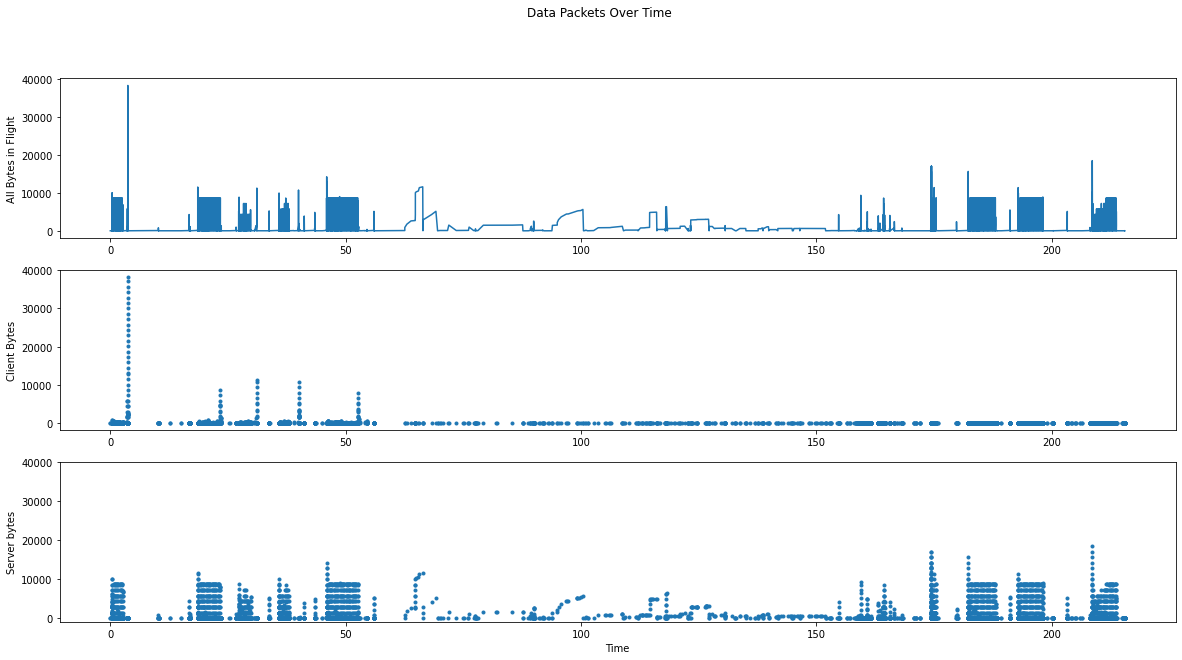

In [13]:
plt.rcParams["figure.figsize"] = (20,10)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle('Data Packets Over Time')

ax1.plot(df['Time'], df['Bytes_in_flight'], '-')
ax1.set_ylabel('All Bytes in Flight')

ax2.plot(df['Time'], df['Client_bytes'], '.')
ax2.set_ylabel('Client Bytes')

ax3.plot(df['Time'], df['Server_bytes'], '.')
ax3.set_ylim(top = 40000)
ax3.set_xlabel('Time')
ax3.set_ylabel('Server bytes')

plt.show()

As expected, the server consists of the majority of the traffic observed in this set. A nest device will frequently be pinging the user or google servers to provide updates about its status and other meta-data. For the client-side, there is very little traffic, but there does appear to be an anomaly at the start of the service, indicated by a high data transfer rate. We can explore several techniques to see if this type of anomaly can be detected. 

Anomalies to consider may include:
    
    - Rate of data transfer
    - Size of data transfer
    - Frequency of queries
    - Types of queries
    - Time of queries
    
Most of the anomalies may come from observing the client-side activity, but it would be wise to monitor the server-side activity to make sure its not exposing sensitive data to unauthorized users. 


There are a wide array of models which would be useful for detecting these types of anomalies, some of those are:
    
    - Neural networks (PyTorch or Tensorflow architechtures)
    - Decision trees
    - Clustering
    - Time-series analysis
    - Facebook Prophet
    
Using unsupervised models may be best for the task, until there is enough labeled data to begin using supervised models. Decision trees tend to be good baseline models, which we can use to evaluate the performance-cost tradeoff of the more expensive models. (i.e. neural network models can be time, computationally, and ultimately, financially expensive.)

### Local Outlier Factor (Clustering)

Using the Local Outlier Factor model, we can take advantage of the k-nearest neighbors algorithm. This gives us a measure of how closely related one point is to its k number of neighbors. Applying a threshold of 1200 bytes, I was able to leverage the model and isolate the anomalous data transaction. 

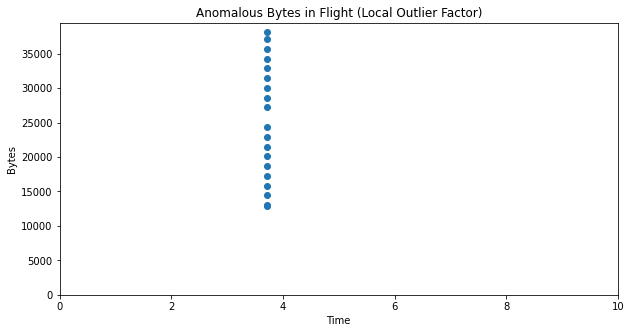

In [31]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
y_pred = clf.fit_predict(df[['Client_bytes']])

lof = pd.DataFrame(y_pred)

plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[(lof[0] < 0)&(df['Bytes_in_flight'] > 1200)]['Time'], df[(lof[0] < 0)&(df['Bytes_in_flight'] > 1200)]['Bytes_in_flight'])
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title('Anomalous Bytes in Flight (Local Outlier Factor)')
plt.ylim(bottom = 0)
plt.xlim(left = 0, right = 10)

plt.show()

### Isolation Forest (Decision Trees)

Using the Isolation Forest decision tree ensemble method, we are able to obtain a cleaner set of anomaly predictions, requiring no post-processing. This model can be further refined, by using a permutation of Isolation Forest, called Extended Isolation forest. 

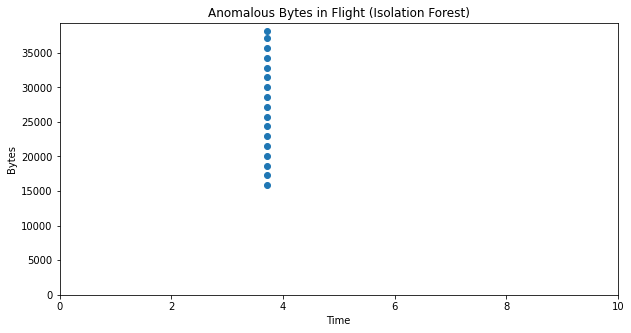

In [32]:
isoforest = IsolationForest(random_state=42, n_jobs=-1, contamination = 0.003)
anomaly_pred = isoforest.fit_predict(df[['Client_bytes']])

iso_df = pd.DataFrame(anomaly_pred)

plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[iso_df[0] < 0]['Time'], df[iso_df[0] < 0]['Bytes_in_flight'])
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title('Anomalous Bytes in Flight (Isolation Forest)')
plt.ylim(bottom = 0)
plt.xlim(left = 0, right = 10)

plt.show()

## Final Thoughts

I've provided two quick and dirty models to detect anomalies, which can act as a baseline for testing more complex models. Neural networks should perform much better, but it would require more training time and thought into the creation of the model. 

Applying these baseline models to the product's architecture would require more training data, minimally a week's worth of data, but optimally at least a month's worth. It would also require capturing all transactions, as they happen in real-time. A router in-front of the device would relay the data to our servers for analysis before being relayed to the device. There would be millisecond delays in user-initiated changes, but the tradeoff for security would be more than worth it. The final requirement before implementation would be testing. To be sure we are able to capture cyber-intrusions/cyber-attacks we would want to validate our models against known/synthesized threats. 